# Nafisur Rahman<br>


# Santander Value Prediction Challenge
   Predict the value of transactions for potential customers.

# Loading libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,KFold,train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error,mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm

%matplotlib inline

In [2]:
df_train=pd.read_csv('../1.All_datasets/Santander_Value_Prediction_Challenge/train.csv')
df_test=pd.read_csv('../1.All_datasets/Santander_Value_Prediction_Challenge/test.csv')

In [3]:
print('Shape of training dataset: ',df_train.shape)
df_train.head()

Shape of training dataset:  (4459, 4993)


,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [4]:
print('Shape of test dataset: ',df_test.shape)
df_test.head()

Shape of test dataset:  (49342, 4992)


,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000137c73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00021489f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0004d7953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00056a333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00056d8eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


## Checking Missing Values

Defining function to check missing values and percentage of missing values in each column.

In [7]:
def check_missing_data(df):
    total=df.isnull().sum().sort_values(ascending=False)
    percent=((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    return pd.concat([total,percent],axis=1,keys=['Total','Percent'])

In [8]:
check_missing_data(df_train).head()

,Total,Percent
9fc776466,0,0.0
083640132,0,0.0
26e2c24e3,0,0.0
c3726f249,0,0.0
a682ef110,0,0.0


In [9]:
check_missing_data(df_test).head()

,Total,Percent
9fc776466,0,0.0
f0aa40974,0,0.0
c3726f249,0,0.0
a682ef110,0,0.0
b452ba57e,0,0.0


# Checking Unique Value in each column
Column with only one unique value is useless. There for we can drop these columns

In [10]:
df_tmp=pd.DataFrame(df_train.nunique().sort_values(),columns=['num_unique_values']).reset_index().rename(columns={'index':'Column_name'})
df_tmp.head()

,Column_name,num_unique_values
0,d9a8615f3,1
1,4a64e56e7,1
2,34cc56e83,1
3,19122191d,1
4,080540c81,1


In [11]:
def col_name_with_n_unique_value(df,n):
    df1=pd.DataFrame(df.nunique().sort_values(),columns=['num_unique_values']).reset_index()
    col_name=list(df1[df1.num_unique_values==1]['index'])
    print('number of columns with only',n,'unique values are: ',len(col_name))
    return col_name

In [12]:
col_to_drop=col_name_with_n_unique_value(df_train,1)

number of columns with only 1 unique values are:  256


### Droping unneccessary columns from train and test dataset

In [13]:
df_train.drop(columns=col_to_drop,inplace=True)
df_test.drop(columns=col_to_drop,inplace=True)
print('Shape of train dataset after droping columns: ',df_train.shape)
print('Shape of test dataset after droping columns: ',df_test.shape)

Shape of train dataset after droping columns:  (4459, 4737)
Shape of test dataset after droping columns:  (49342, 4736)


# Getting Dataset in numpy ndarray format

In [14]:
train=df_train.iloc[:,2:].values
test=df_test.iloc[:,1:].values
target=df_train.target.values
print('Shape of train: ',train.shape)
print('Shape of target: ',target.shape)
print('Shape of test: ',test.shape)

Shape of train:  (4459, 4735)
Shape of target:  (4459,)
Shape of test:  (49342, 4735)


# Visualization of target Column

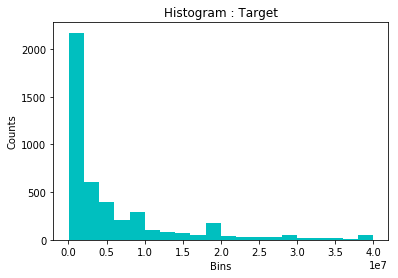

In [15]:
plt.hist(target, bins=20, color='c')
plt.title('Histogram : Target')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.show()

Target values ranges from 0 to 4*1e7. there for taking log will reduce the range

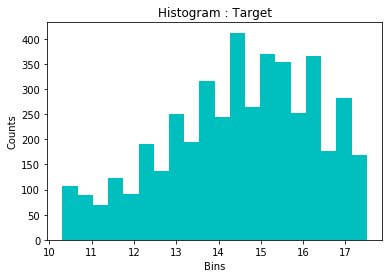

In [16]:
t=np.log1p(target)
plt.hist(t, bins=20, color='c')
plt.title('Histogram : Target')
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.show()

# Feature Scaling

In [17]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# Splitting dataset into Train, val and Test set
We split the dataset into train and val sets using an 80/20 split.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_sc, t, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(test_sc.shape, test_sc.shape)

(3567, 4735) (3567,)
(892, 4735) (892,)
(49342, 4735) (49342, 4735)


# Machine Learning Models

In [19]:
Model_Summary=pd.DataFrame()

## 1. Lightgbm

In [26]:
import lightgbm
train_data=lightgbm.Dataset(X_train,y_train)
valid_data=lightgbm.Dataset(X_val,y_val)

In [28]:
params={'learning_rate':0.01,
        'boosting_type':'gbdt',
        'objective':'regression',
        'metric':'rmse',
        'sub_feature':0.5,
        'num_leaves':180,
        'feature_fraction': 0.5,
        'bagging_fraction': 0.5,
        'min_data':50,
        'max_depth':-1,
        'reg_alpha': 0.3, 
        'reg_lambda': 0.1, 
        'min_child_weight': 10, 
        'verbose': 1,
        'nthread':5,
        'max_bin':512,
        'subsample_for_bin':200,
        'min_split_gain':0.0001,
        'min_child_samples':5
       }

In [29]:
lgbm = lightgbm.train(params,
                 train_data,
                 25000,
                 valid_sets=valid_data,evals_result=None,
                 early_stopping_rounds= 80,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 80 rounds.
[10]	valid_0's rmse: 1.68329
[20]	valid_0's rmse: 1.65379
[30]	valid_0's rmse: 1.62585
[40]	valid_0's rmse: 1.60281
[50]	valid_0's rmse: 1.58241
[60]	valid_0's rmse: 1.5628
[70]	valid_0's rmse: 1.5459
[80]	valid_0's rmse: 1.53187
[90]	valid_0's rmse: 1.51927
[100]	valid_0's rmse: 1.50833
[110]	valid_0's rmse: 1.49785
[120]	valid_0's rmse: 1.48871
[130]	valid_0's rmse: 1.48048
[140]	valid_0's rmse: 1.47291
[150]	valid_0's rmse: 1.46649
[160]	valid_0's rmse: 1.46096
[170]	valid_0's rmse: 1.45499
[180]	valid_0's rmse: 1.44949
[190]	valid_0's rmse: 1.44445
[200]	valid_0's rmse: 1.44019
[210]	valid_0's rmse: 1.43617
[220]	valid_0's rmse: 1.4328
[230]	valid_0's rmse: 1.42932
[240]	valid_0's rmse: 1.42637
[250]	valid_0's rmse: 1.42363
[260]	valid_0's rmse: 1.42086
[270]	valid_0's rmse: 1.4183
[280]	valid_0's rmse: 1.4167
[290]	valid_0's rmse: 1.41482
[300]	valid_0's rmse: 1.41316
[310]	valid_0's rmse: 1.41174
[320]	valid_0's rmse: 

In [30]:
model_name='lightgbm'
RMSLE=np.sqrt(mean_squared_error(y_val,lgbm.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

,Model_Name,RMSLE
0,CatBoostRegressor,1.449733
1,lightgbm,1.401956


In [29]:
pred_lgbm=np.expm1(lgbm.predict(test_sc))
pred_lgbm

array([1236035.77361614, 2025028.31139007, 3395527.3251378 , ...,
        889721.93901169,  283838.89779106, 2029775.38726844])

## 2. CatBoostRegressor

In [20]:
from catboost import CatBoostRegressor

In [22]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.1,
                             depth=5,
                             l2_leaf_reg=20,
                             bootstrap_type='Bernoulli',
                             subsample=0.6,
                             eval_metric='RMSE',
                             random_seed = 42,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=45)

In [23]:
cb_model.fit(X_train, y_train,
             eval_set=(X_val, y_val),
             use_best_model=True,
             verbose=True)

0:	learn: 13.1734018	test: 13.2419635	best: 13.2419635 (0)	total: 384ms	remaining: 3m 11s
50:	learn: 1.6790864	test: 1.6631863	best: 1.6631863 (50)	total: 10.8s	remaining: 1m 34s
100:	learn: 1.5105776	test: 1.5339704	best: 1.5339704 (100)	total: 21.1s	remaining: 1m 23s
150:	learn: 1.4060365	test: 1.4878651	best: 1.4877407 (149)	total: 31.6s	remaining: 1m 12s
200:	learn: 1.3456421	test: 1.4748221	best: 1.4748221 (200)	total: 41.9s	remaining: 1m 2s
250:	learn: 1.3021953	test: 1.4699754	best: 1.4699754 (250)	total: 52.3s	remaining: 51.9s
300:	learn: 1.2626050	test: 1.4626305	best: 1.4626305 (300)	total: 1m 2s	remaining: 41.4s
350:	learn: 1.2301768	test: 1.4582470	best: 1.4578189 (341)	total: 1m 12s	remaining: 31s
400:	learn: 1.2007596	test: 1.4558918	best: 1.4555656 (399)	total: 1m 23s	remaining: 20.6s
450:	learn: 1.1747597	test: 1.4532322	best: 1.4531226 (447)	total: 1m 33s	remaining: 10.2s

bestTest = 1.449732727
bestIteration = 480

Shrink model to first 481 iterations.


In [24]:
model_name='CatBoostRegressor'
RMSLE=np.sqrt(mean_squared_error(y_val,cb_model.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

,Model_Name,RMSLE
0,CatBoostRegressor,1.449733


In [25]:
pred_cb=np.expm1(cb_model.predict(test_sc))
pred_cb

array([1112396.108769  , 1205793.70003429, 1637320.4494433 , ...,
        816539.47213956,  500173.32646464, 1840858.68367049])

## 3. RandomForestRegressor

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
rf_model = RandomForestRegressor(n_estimators=400, n_jobs=-1,oob_score = True,random_state =1, max_depth=8,
                                 max_features = "auto",verbose=1,bootstrap=True,max_leaf_nodes=31)

In [37]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  2.2min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features='auto', max_leaf_nodes=31,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=True, random_state=1, verbose=1, warm_start=False)

In [38]:
model_name='RandomForestRegressor'
RMSLE=np.sqrt(mean_squared_error(y_val,rf_model.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.0s finished


,Model_Name,RMSLE
0,lightgbm,1.402756
1,CatBoostRegressor,1.466294
2,RandomForestRegressor,1.499233


In [40]:
pred_rf=np.expm1(rf_model.predict(test_sc))
pred_rf

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


array([1741577.35385211, 1734606.28489647, 2182935.61593154, ...,
       1302836.89466743,  814948.62691805, 1734606.28489647])

## 4. Keras Neural Network

In [31]:
from keras.layers import Dense,Dropout,Input
from keras.models import Sequential,Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.losses import MSLE,mse,msle

Using TensorFlow backend.


In [32]:
in_shape=X_train[0].shape
b_size=128

In [33]:
input1=Input(shape=in_shape)
x1=Dense(512,activation='relu',kernel_initializer='normal')(input1)
x2=Dense(256,activation='relu',kernel_initializer='normal')(x1)
x3=Dropout(0.2)(x2)
x4=Dense(256,activation='relu',kernel_initializer='normal')(x3)
x5=Dropout(0.2)(x4)
x6=Dense(256,activation='relu',kernel_initializer='normal')(x5)
x7=Dropout(0.2)(x6)
x = Dense(1, activation='linear',kernel_initializer='normal')(x7)
keras_model = Model(inputs=input1, outputs=x)

In [34]:
keras_model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [35]:
Rlr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_lr=0.0001)
Es = EarlyStopping(monitor='val_loss', 
                   min_delta=0.00005, 
                   patience=3, 
                   verbose=1, 
                   mode='auto')

In [37]:
history = keras_model.fit(X_train, y_train, 
          epochs=50,
          batch_size=b_size,
          callbacks=[Rlr],
          validation_data=(X_val, y_val))

Train on 3567 samples, validate on 892 samples
Epoch 1/50
3567/3567 [==============================] - 1s 404us/step - loss: 2.3754 - mean_squared_error: 2.3754 - val_loss: 5.3016 - val_mean_squared_error: 5.3016
Epoch 2/50
3567/3567 [==============================] - 1s 396us/step - loss: 2.2973 - mean_squared_error: 2.2973 - val_loss: 5.3690 - val_mean_squared_error: 5.3690
Epoch 3/50
3567/3567 [==============================] - 1s 401us/step - loss: 2.2400 - mean_squared_error: 2.2400 - val_loss: 5.2742 - val_mean_squared_error: 5.2742
Epoch 4/50
3567/3567 [==============================] - 1s 393us/step - loss: 2.1379 - mean_squared_error: 2.1379 - val_loss: 5.7217 - val_mean_squared_error: 5.7217
Epoch 5/50
3567/3567 [==============================] - 1s 389us/step - loss: 2.1647 - mean_squared_error: 2.1647 - val_loss: 5.3379 - val_mean_squared_error: 5.3379
Epoch 6/50
3567/3567 [==============================] - 1s 389us/step - loss: 2.1694 - mean_squared_error: 2.1694 - val_los

Epoch 49/50
3567/3567 [==============================] - 1s 388us/step - loss: 1.2468 - mean_squared_error: 1.2468 - val_loss: 4.7880 - val_mean_squared_error: 4.7880
Epoch 50/50
3567/3567 [==============================] - 1s 399us/step - loss: 1.2772 - mean_squared_error: 1.2772 - val_loss: 4.7711 - val_mean_squared_error: 4.7711


In [38]:
model_name='Keras_ANN'
RMSLE=np.sqrt(mean_squared_error(y_val,keras_model.predict(X_val)))
Model_Summary=Model_Summary.append({'Model_Name':model_name,'RMSLE':RMSLE},ignore_index=True)
Model_Summary

,Model_Name,RMSLE
0,CatBoostRegressor,1.449733
1,lightgbm,1.401956
2,Keras_ANN,2.184278


In [ ]:
pred_KNN=np.expm1(keras_model.predict(test_sc))
pred_KNN

# Generating Submision File

**generating submission file for 3 model**

In [43]:
Model_Summary

,Model_Name,RMSLE
0,lightgbm,1.402756
1,CatBoostRegressor,1.466294
2,RandomForestRegressor,1.499233


In [41]:
sub=pd.read_csv('../1.All_datasets/Santander_Value_Prediction_Challenge/sample_submission.csv')
sub.target=(pred_lgbm+pred_cb+pred_rf)/3.0
sub.head()

,ID,target
0,000137c73,1.180227e+06
1,00021489f,1.813976e+06
2,0004d7953,2.505474e+06
3,00056a333,4.521924e+06
4,00056d8eb,1.552905e+06


In [42]:
sub.to_csv('sub1.csv',index=False)